In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import sys
import os
sys.path.append(os.path.abspath('..'))
from kans import BSplineKAN, FourierKAN, GaussianKAN, JacobiKAN, RationalKAN, TaylorKAN, WaveletKAN
from kans.utils import create_dataset

torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [2]:
def train(model, train_loader, num_epochs=50, save=False, model_name=''):
	print(f'Training {model_name} model...')
	optimizer = optim.Adam(model.parameters(), lr=0.01)
	criterion = nn.MSELoss()
	epoch_losses = []
	bar = tqdm(total=num_epochs)
	start_t = time.time()
	for epoch in range(num_epochs):
		running_loss = 0.0
		for i, (inputs, labels) in enumerate(train_loader):
            # 前向传播
			outputs = model(inputs)
			loss = criterion(outputs, labels)
            
            # 反向传播和优化
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
            
            # 记录损失
			running_loss += loss.item()
        
        # 每个epoch结束后输出平均损失
		epoch_loss = running_loss / len(train_loader)
		epoch_losses.append(epoch_loss)
		bar.set_description(f'{model_name} Epoch {epoch+1}')
		bar.set_postfix(loss=f'{epoch_loss:.4f}')
		bar.update(1)
	bar.close()
	end_t = time.time()
	epoch_time = (end_t - start_t) / num_epochs
	print(f'Average Epoch Training Time :{epoch_time}s')
	if save:
		torch.save(model.state_dict(), f'model/{model_name}.pth')
		print(f'Model saved as model/{model_name}.pth')
	return epoch_losses, epoch_time

def test(model, test_input, test_label, model_name):
	model.eval()
	criterion = nn.MSELoss()
	with torch.no_grad():
		test_output = model(test_input)
	test_loss = criterion(test_output, test_label).item()
	print(f'Test Loss of {model_name}: {test_loss:.4f}')
	return test_loss

In [3]:
# 生成数据集
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, device=device)
print('train_input size:', dataset['train_input'].shape)
print('train_label',dataset['train_label'].shape)
print('test_input size:', dataset['test_input'].shape)
print('test_label',dataset['test_label'].shape)

# 创建数据加载器
train_dataset = TensorDataset(dataset['train_input'], dataset['train_label'])
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_input size: torch.Size([1000, 2])
train_label torch.Size([1000, 1])
test_input size: torch.Size([1000, 2])
test_label torch.Size([1000, 1])


In [4]:
# 模型设置: 设每层可学习参数数量为：input_size * output_size * (p + 1)
layer_sizes = [2,5,3,1]  # 指定每层的节点数

# b_kan: p = b_grid_count
b_order = 3  # B-spline的阶数
b_grid_range = [-1,1]  # 网格范围
b_grid_count = 9  # 网格数量

# f_kan: p = frequency_count * 2 + 1
frequency_count = 4  # 初始傅里叶频率数

# g_kan: p = g_grid_count
g_grid_range = [-1,1]  # 指定径向基函数的中心范围
g_grid_count = 9 # 指定径向基函数的数量

# j_kan: p = j_order + 1
j_order = 8  # Jacobi多项式阶数
alpha = 0.5  # Jacobi多项式的alpha参数
beta = 0.5  # Jacobi多项式的beta参数

# r_kan: p = mole_order + deno_order + 1
mole_order = 5  # 分子阶数
deno_order = 3  # 分母阶数

# t_kan: p = t_order + 1
t_order = 8  # Taylor多项式阶数

# w_kan: p = wave_num * 3
wave_num = 3  # 小波基函数的数量
wave_type = 'morlet'  # 小波基函数的类型

In [5]:
# 训练和测试模型

# b_kan
model = BSplineKAN(layer_sizes, b_order, b_grid_range, b_grid_count).to(device)
b_epoch_losses, b_epoch_time = train(model, train_loader, num_epochs=50, save=True, model_name='BSplineKAN')
b_test_loss = test(model, dataset['test_input'], dataset['test_label'], 'BSplineKAN')
del model
torch.cuda.empty_cache()

# f_kan
model = FourierKAN(layer_sizes, frequency_count).to(device)
f_epoch_losses, f_epoch_time = train(model, train_loader, num_epochs=50, save=True, model_name='FourierKAN')
f_test_loss = test(model, dataset['test_input'], dataset['test_label'], 'FourierKAN')
del model
torch.cuda.empty_cache()

# g_kan
model = GaussianKAN(layer_sizes, g_grid_range, g_grid_count).to(device)
g_epoch_losses, g_epoch_time = train(model, train_loader, num_epochs=50, save=True, model_name='GaussianKAN')
g_test_loss = test(model, dataset['test_input'], dataset['test_label'], 'GaussianKAN')
del model
torch.cuda.empty_cache()

# j_kan
model = JacobiKAN(layer_sizes, j_order, alpha, beta).to(device)
j_epoch_losses, j_epoch_time = train(model, train_loader, num_epochs=50, save=True, model_name='JacobiKAN')
j_test_loss = test(model, dataset['test_input'], dataset['test_label'], 'JacobiKAN')
del model
torch.cuda.empty_cache()

# r_kan
model = RationalKAN(layer_sizes, mole_order, deno_order).to(device)
r_epoch_losses, r_epoch_time = train(model, train_loader, num_epochs=50, save=True, model_name='RationalKAN')
r_test_loss = test(model, dataset['test_input'], dataset['test_label'], 'RationalKAN')
del model
torch.cuda.empty_cache()

# t_kan
model = TaylorKAN(layer_sizes, t_order).to(device)
t_epoch_losses, t_epoch_time = train(model, train_loader, num_epochs=50, save=True, model_name='TaylorKAN')
t_test_loss = test(model, dataset['test_input'], dataset['test_label'], 'TaylorKAN')
del model
torch.cuda.empty_cache()

# w_kan
model = WaveletKAN(layer_sizes, wave_num, wave_type).to(device)
w_epoch_losses, w_epoch_time = train(model, train_loader, num_epochs=50, save=True, model_name='WaveletKAN')
w_test_loss = test(model, dataset['test_input'], dataset['test_label'], 'WaveletKAN')
del model
torch.cuda.empty_cache()

Training BSplineKAN model...


BSplineKAN Epoch 50: 100%|████████████████████████████████████████████████| 50/50 [01:41<00:00,  2.02s/it, loss=0.0074]


Average Epoch Training Time :2.0242364406585693s
Model saved as model/BSplineKAN.pth
Test Loss of BSplineKAN: 0.0083
Training FourierKAN model...


FourierKAN Epoch 50: 100%|████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.22s/it, loss=0.0191]


Average Epoch Training Time :1.2164105224609374s
Model saved as model/FourierKAN.pth
Test Loss of FourierKAN: 0.0488
Training GaussianKAN model...


GaussianKAN Epoch 50: 100%|███████████████████████████████████████████████| 50/50 [01:04<00:00,  1.29s/it, loss=0.0013]


Average Epoch Training Time :1.2857211685180665s
Model saved as model/GaussianKAN.pth
Test Loss of GaussianKAN: 0.0014
Training JacobiKAN model...


JacobiKAN Epoch 50: 100%|█████████████████████████████████████████████████| 50/50 [01:16<00:00,  1.53s/it, loss=0.0007]


Average Epoch Training Time :1.528876028060913s
Model saved as model/JacobiKAN.pth
Test Loss of JacobiKAN: 0.0004
Training RationalKAN model...


RationalKAN Epoch 50: 100%|███████████████████████████████████████████████| 50/50 [01:05<00:00,  1.32s/it, loss=0.0012]


Average Epoch Training Time :1.319322829246521s
Model saved as model/RationalKAN.pth
Test Loss of RationalKAN: 0.0010
Training TaylorKAN model...


TaylorKAN Epoch 50: 100%|█████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s, loss=0.0058]


Average Epoch Training Time :0.9791888904571533s
Model saved as model/TaylorKAN.pth
Test Loss of TaylorKAN: 0.0042
Training WaveletKAN model...


WaveletKAN Epoch 50: 100%|████████████████████████████████████████████████| 50/50 [01:25<00:00,  1.71s/it, loss=0.0064]

Average Epoch Training Time :1.706172776222229s
Model saved as model/WaveletKAN.pth
Test Loss of WaveletKAN: 0.0018


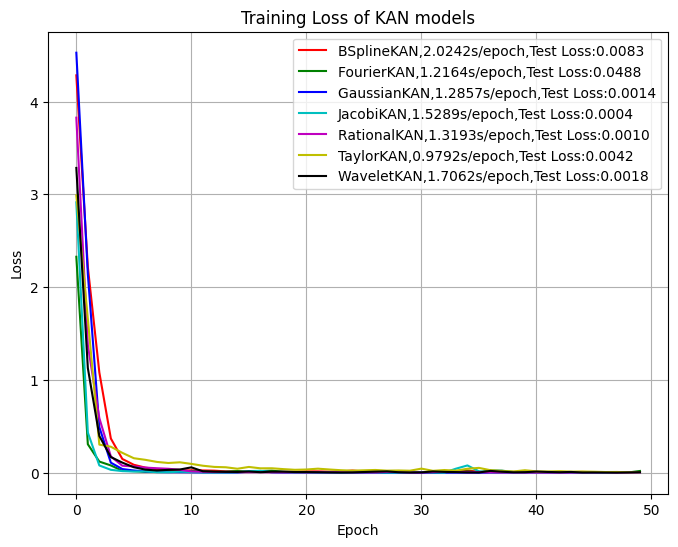

In [6]:
# 画出损失曲线
plt.figure(figsize=(8,6))
plt.plot(b_epoch_losses, label=f'BSplineKAN,{b_epoch_time:.4f}s/epoch,Test Loss:{b_test_loss:.4f}', color='r')
plt.plot(f_epoch_losses, label=f'FourierKAN,{f_epoch_time:.4f}s/epoch,Test Loss:{f_test_loss:.4f}', color='g')
plt.plot(g_epoch_losses, label=f'GaussianKAN,{g_epoch_time:.4f}s/epoch,Test Loss:{g_test_loss:.4f}', color='b')
plt.plot(j_epoch_losses, label=f'JacobiKAN,{j_epoch_time:.4f}s/epoch,Test Loss:{j_test_loss:.4f}', color='c')
plt.plot(r_epoch_losses, label=f'RationalKAN,{r_epoch_time:.4f}s/epoch,Test Loss:{r_test_loss:.4f}', color='m')
plt.plot(t_epoch_losses, label=f'TaylorKAN,{t_epoch_time:.4f}s/epoch,Test Loss:{t_test_loss:.4f}', color='y')
plt.plot(w_epoch_losses, label=f'WaveletKAN,{w_epoch_time:.4f}s/epoch,Test Loss:{w_test_loss:.4f}', color='k')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss of KAN models')
plt.grid(True)
plt.legend()
plt.show()